# Numerical Studies
Through out the simulations, we only work on linear measurement models.
The three examples contain: low dimensional linear, low dimensional non-linear, and high dimensional non-linear cases.

# Example 1: Van der Pol Oscillator from gillijns2006ensemble
Here, I first try the original EnKF with different ensemble sizes. 
This is a low-order example.

## Define the EnFK function
This defines the original EnKF for non-linear systems. 
Note that `process_model` and `observation_model` are problem dependent. 
The function defined here is for $y$ being a real value (1 dim).

In [258]:
import numpy as np
import matplotlib.pyplot as plt

class EnsembleKalmanFilter:
    def __init__(self, ensemble_size, state_dim, process_model, observation_model, R, Q):
        """
        :param ensemble_size: Number of ensemble members
        :param state_dim: Dimensionality of the state vector
        :param process_model: Function to predict the next state
        :param observation_model: Function to map the state to observations
        :param R: Observation noise covariance matrix
        :param Q: Process noise covariance matrix
        """
        self.ensemble_size = ensemble_size
        self.state_dim = state_dim
        self.process_model = process_model
        self.observation_model = observation_model
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.ensemble = None

    def initialize_ensemble(self, initial_state, spread=1.0):
        """
        Initializes the ensemble around an initial state.
        :param initial_state: The initial state vector (numpy array)
        :param spread: Spread for random perturbations around the initial state
        """
        self.ensemble = np.array([initial_state + spread * np.random.randn(self.state_dim) for _ in range(self.ensemble_size)])

    def predict(self):
        """
        Applies the process model to predict the next state for each ensemble member.
        """
        for i in range(self.ensemble_size):
            if np.isscalar(self.Q) or self.Q.ndim == 1:
                process_noise = np.random.normal(0, self.Q, self.state_dim)
            else:
                process_noise = np.random.multivariate_normal(np.zeros(self.state_dim), self.Q)
            self.ensemble[i] = self.process_model(self.ensemble[i]) + process_noise

    def update(self, observation):
        if np.isscalar(observation):
            observation = np.atleast_1d(observation)
        """
        Updates the ensemble based on the observation.
        :param observation: Observation vector (numpy array)
        """
        # Compute ensemble mean and observation mean
        ensemble_mean = np.mean(self.ensemble, axis=0)
        ensemble_observations = np.array([self.observation_model(member) for member in self.ensemble])
        observation_mean = np.mean(ensemble_observations, axis=0)

        # Compute innovation covariance and Kalman gain
        P_yy = np.cov(ensemble_observations, rowvar=False) + self.R
        # Extract only the covariance part
        P_xy = np.cov(self.ensemble.T, ensemble_observations.T)[:self.state_dim, self.state_dim:]

        # Handle 1D case for P_yy and P_xy
        if np.isscalar(P_yy) or P_yy.ndim == 0:
            P_yy = P_yy.reshape(1, 1)
        if np.isscalar(P_xy) or P_xy.ndim == 0:
            P_xy = P_xy.reshape(-1, 1)

        K = P_xy @ np.linalg.inv(P_yy)

        # Update each ensemble member
        for i in range(self.ensemble_size):
            if np.isscalar(self.R):
                innovation_noise = np.random.normal(0, self.R, 1) if np.isscalar(observation) else np.random.normal(0, self.R, len(observation))
            elif self.R.ndim == 1:
                innovation_noise = np.random.normal(0, self.R, len(observation))
            else:
                innovation_noise = np.random.multivariate_normal(np.zeros(len(observation)), self.R)
            innovation = observation + innovation_noise - ensemble_observations[i]
            if np.isscalar(innovation) or innovation.ndim == 0:
                innovation = np.array([innovation])
            self.ensemble[i] += (K @ innovation).flatten()

    def get_state_estimate(self):
        """
        Returns the current state estimate (mean of the ensemble).
        """
        return np.mean(self.ensemble, axis=0)
    
    def get_variance_estimate(self):
        return np.std(self.ensemble, axis=0)


## Define processes for the problem
The process is given by
$$
x_{k+1}=f\left(x_k\right),
$$

where $x_k=\left[\begin{array}{ll}x_{1, k} & x_{2, k}\end{array}\right]^{\mathrm{T}}$,

$$
f\left(x_k\right)=\left[\begin{array}{c}
x_{1, k}+h x_{2, k} \\
x_{2, k}+h\left(\alpha\left(1-x_{1, k}^2\right) x_{2, k}-x_{1, k}\right)
\end{array}\right],
$$

and $h$ is the step size. We assume that the Van der Pol oscillator is driven by $w_k$, that is,

$$
x_{k+1}=f\left(x_k\right)+w_k,
$$

where $w_k \in \mathbb{R}^2$ is zero-mean white Gaussian noise with covariance matrix $Q \in \mathbb{R}^{2 \times 2}$. We assume that for all $k \geqslant 0$, measurements of either $x_{1, k}$ or $x_{2, k}$ are available so that

$$
y_k=C x_k+v_k,
$$

where $v_k \in \mathbb{R}$ is zero mean white Gaussian noise with covariance $R>0$ and $C$ selects $x_{1, k}$ or $x_{2, k}$. The objective

In [259]:
# State transition function for Van der Pol oscillator
# The models are without noises
def process_model(state):
    x1, x2 = state
    dx1 = x1 + h * x2
    dx2 = x2 + h * (alpha * (1 - x1**2) * x2 - x1)
    return np.array([dx1, dx2])

def observation_model(state):
    return C @ state

## Generate data and set parameters as in the paper


In [260]:
# Define parameters
np.random.seed(999)
state_dim = 2
R = 0.5 # Observation noise covariance
Q = np.diag([0.0262, 0.008])  # Process noise covariance
alpha = 1.0  # Parameter for the Van der Pol oscillator
h = 0.1      # Step size
C = np.array([0, 1])
T = 500  # Total time steps
inflation = 1
initial_state = np.zeros(state_dim)

# Generate data and the true states
w = np.random.multivariate_normal(np.zeros(state_dim), Q)
true_states = np.array([process_model(initial_state) + w])
v = np.random.normal(0, R)
observations = np.array([observation_model(true_states[0,])+ v])

for t in range(T):
    w = np.random.multivariate_normal(np.zeros(state_dim), Q)
    true_state = process_model(true_states[t,]) + w
    true_states = np.append(true_states, [true_state], axis=0)
    if t+1 == T:
        break
    v = np.random.normal(0, R)
    observation = observation_model(true_states[t+1]) + v
    observations = np.append(observations, [observation], axis=0)

observations = observations.reshape(-1, 1)
print("True states shape", np.shape(true_states))
print("Observations shape", np.shape(observations))

True states shape (501, 2)
Observations shape (500, 1)


## Implement and visualize the original EnKF with ensemble sizes (10, 30, 50)
Implement EnKF.


In [261]:
# Implement the EnFK
np.random.seed(999)

# Ensemble size 30
ensemble_size = 30
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_30 = []
result_x2_30 = []
var_x1_30 = []
var_x2_30 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_30.append(enkf.get_state_estimate()[0])
  result_x2_30.append(enkf.get_state_estimate()[1])
  var_x1_30.append(enkf.get_variance_estimate()[0])
  var_x2_30.append(enkf.get_variance_estimate()[1])

# Ensemble size 10
ensemble_size = 10
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_10 = []
result_x2_10 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_10.append(enkf.get_state_estimate()[0])
  result_x2_10.append(enkf.get_state_estimate()[1])

# Ensemble size 5
ensemble_size = 5
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)
result_x1_5 = []
result_x2_5 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_5.append(enkf.get_state_estimate()[0])
  result_x2_5.append(enkf.get_state_estimate()[1])

Visualize and compute the MSEs and confidence interval.

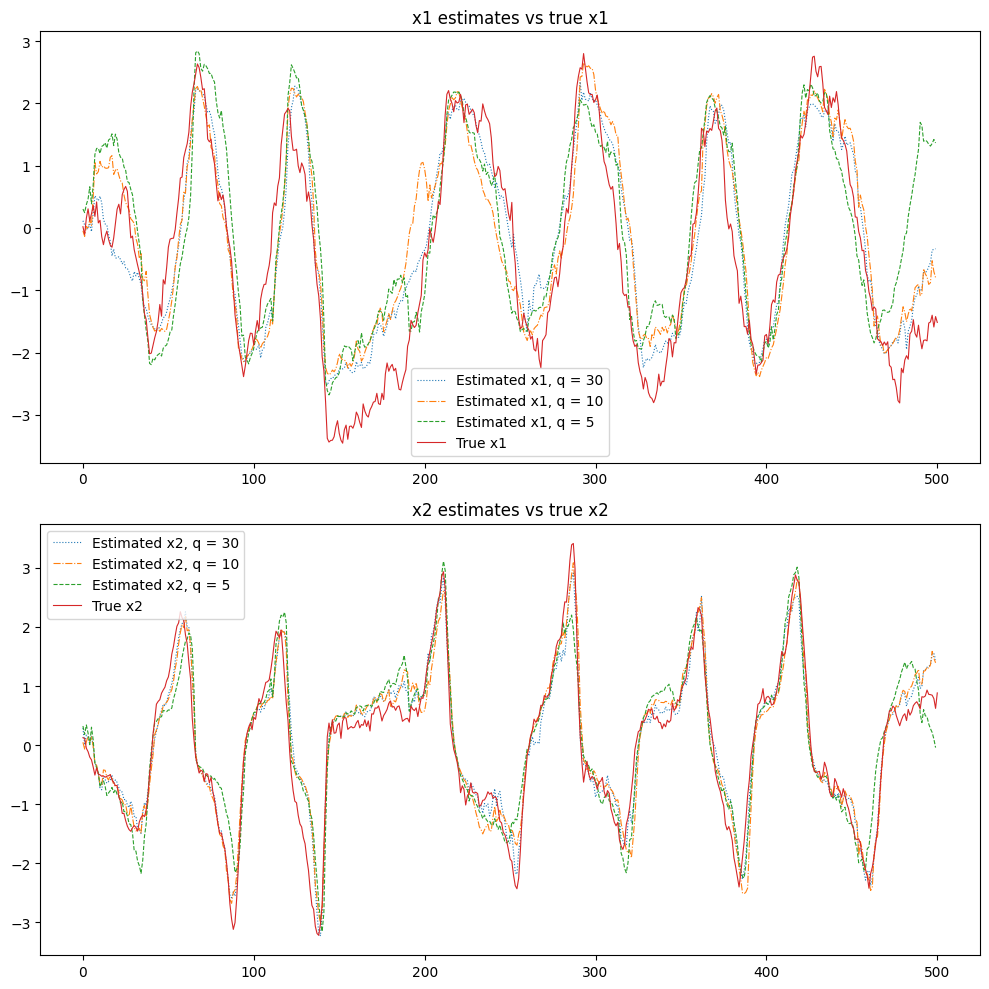

MSE x1, q = 30: 0.5
MSE x2, q = 30: 0.18
MSE x1, q = 10: 0.68
MSE x2, q = 10: 0.24
MSE x1, q = 5: 1.0
MSE x2, q = 5: 0.29


In [262]:
# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1, q = 30")
axs[0].plot(result_x1_10, linestyle='-.', linewidth=0.8, label="Estimated x1, q = 10")
axs[0].plot(result_x1_5, linestyle='--', linewidth=0.8, label="Estimated x1, q = 5")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1")
axs[0].set_title("x1 estimates vs true x1")
axs[0].legend()


axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2, q = 30")
axs[1].plot(result_x2_10, linestyle='-.', linewidth=0.8, label="Estimated x2, q = 10")
axs[1].plot(result_x2_5, linestyle='--', linewidth=0.8, label="Estimated x2, q = 5")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2")
axs[1].set_title("x2 estimates vs true x2")
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("EnKF_different_ensemble_sizes.png")
plt.show()


# MSEs
MSE_x1_30 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
MSE_x2_30 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
MSE_x1_10 = np.mean((np.array(result_x1_10) - true_states[1:, 0])**2)
MSE_x2_10 = np.mean((np.array(result_x2_10) - true_states[1:, 1])**2)
MSE_x1_5 = np.mean((np.array(result_x1_5) - true_states[1:, 0])**2)
MSE_x2_5 = np.mean((np.array(result_x2_5) - true_states[1:, 1])**2)

print(f"MSE x1, q = 30: {MSE_x1_30:.2}")
print(f"MSE x2, q = 30: {MSE_x2_30:.2}")
print(f"MSE x1, q = 10: {MSE_x1_10:.2}")
print(f"MSE x2, q = 10: {MSE_x2_10:.2}")
print(f"MSE x1, q = 5: {MSE_x1_5:.2}")
print(f"MSE x2, q = 5: {MSE_x2_5:.2}")

From this figure, we observe that a larger ensemble size leads to a better fit.
The MSEs computed for $x_1$ and $x_2$ are reported as follows:

**MSEs for Different Ensemble Sizes (EnKF)**

| Ensemble Size ($q$) | RMSE ($x_1$) | RMSE ($x_2$) |
|-------------------|----------|----------|
| 30                | 0.5      | 0.18     |
| 10                | 0.68     | 0.24     |
| 5                 | 1.0      | 0.29     |

We chose $q$ such that it aligns the $q$ used in [[gillijns2006ensemble]]. For a high dimensional problem 50~100 ensemble members is typically enough [[gillijns2006ensemble.1.6]]. This justifies the use of $q = 30$ here.

This result was expected as more $q$ generally gives a better approximation of the covariance of forecast states since the sampling error becomes smaller. In fact, $q \leq 10$ can capture the trend well. It is worth mentioning that EnKF generally underestimates the posterior covariance of the posterior state [[katzfuss2016understanding]], especially when the ensmeble size is small. As can be seen in the osilation of EnKF estimates is smaller than that of the true states. This problem can be resolved be variance inflation Sec7.6.2. [[bach2024inverse]] and Sec 10.3. [[evensen2022data]].

## Use $2R$ in the EnFK and compare the result from $R$, $q = 30$


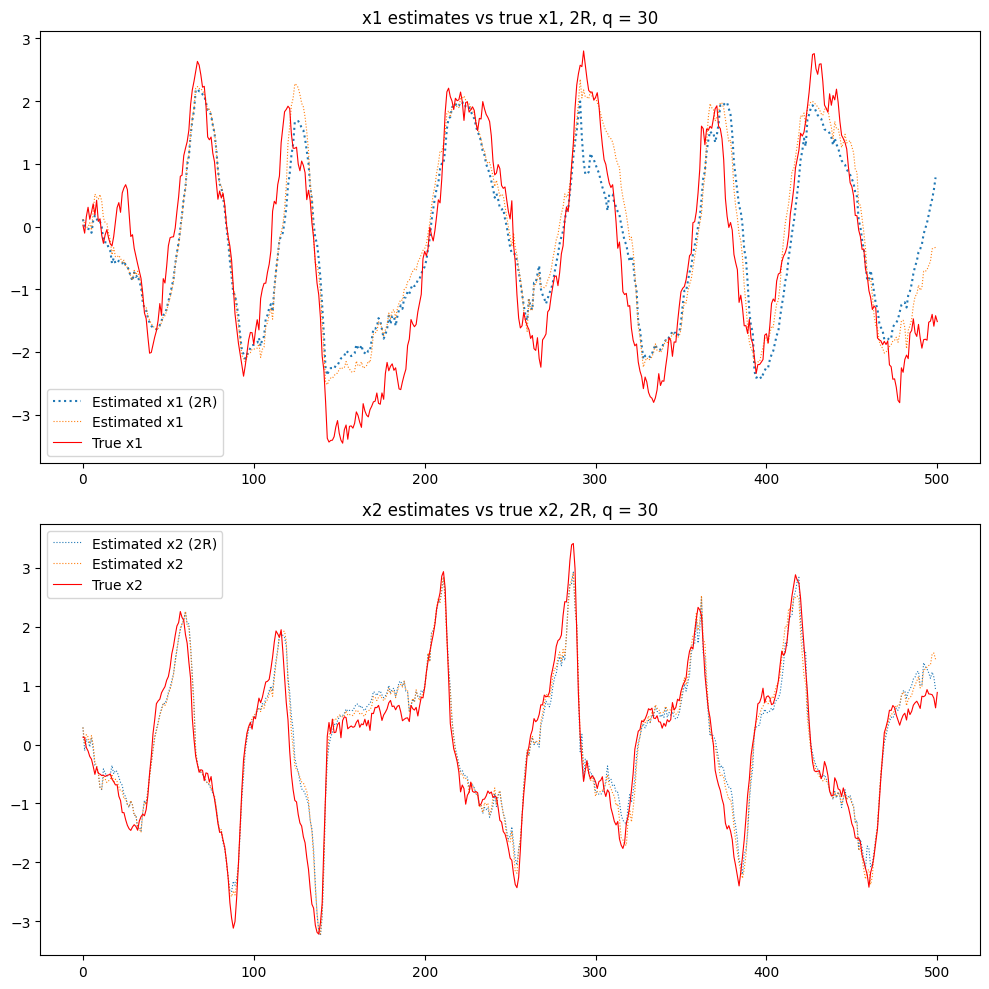

In [263]:
np.random.seed(999)
R1 = R*2  # Observation noise covariance
ensemble_size = 30

# Instantiate and initialize EnKF
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R1, Q)
enkf.initialize_ensemble(initial_state)

result_x1_two = []
result_x2_two = []
var_x1_30_two = []
var_x2_30_two = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_two.append(enkf.get_state_estimate()[0])
  result_x2_two.append(enkf.get_state_estimate()[1])
  var_x1_30_two.append(enkf.get_variance_estimate()[0])
  var_x2_30_two.append(enkf.get_variance_estimate()[1])

# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_two, linestyle=':', label="Estimated x1 (2R)")
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1", color="red")
axs[0].set_title("x1 estimates vs true x1, 2R, q = " + str(ensemble_size))
axs[0].legend()

axs[1].plot(result_x2_two, linestyle=':', linewidth=0.8, label="Estimated x2 (2R)")
axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2", color="red")
axs[1].set_title("x2 estimates vs true x2, 2R, q = " + str(ensemble_size))
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("EnKF_different_observation_noise.png")
plt.show()

The figure implies that the estimates using $2R$ fluctuates less than that from the plain EnKF and the true states. This was expected in the simulation since simply using $2R$ deflates the estimates. 

## Compute MSEs and confidence intervals

MSE x1 (2R): 0.62
MSE x2 (2R): 0.21
MSE x1: 0.5
MSE x2: 0.18


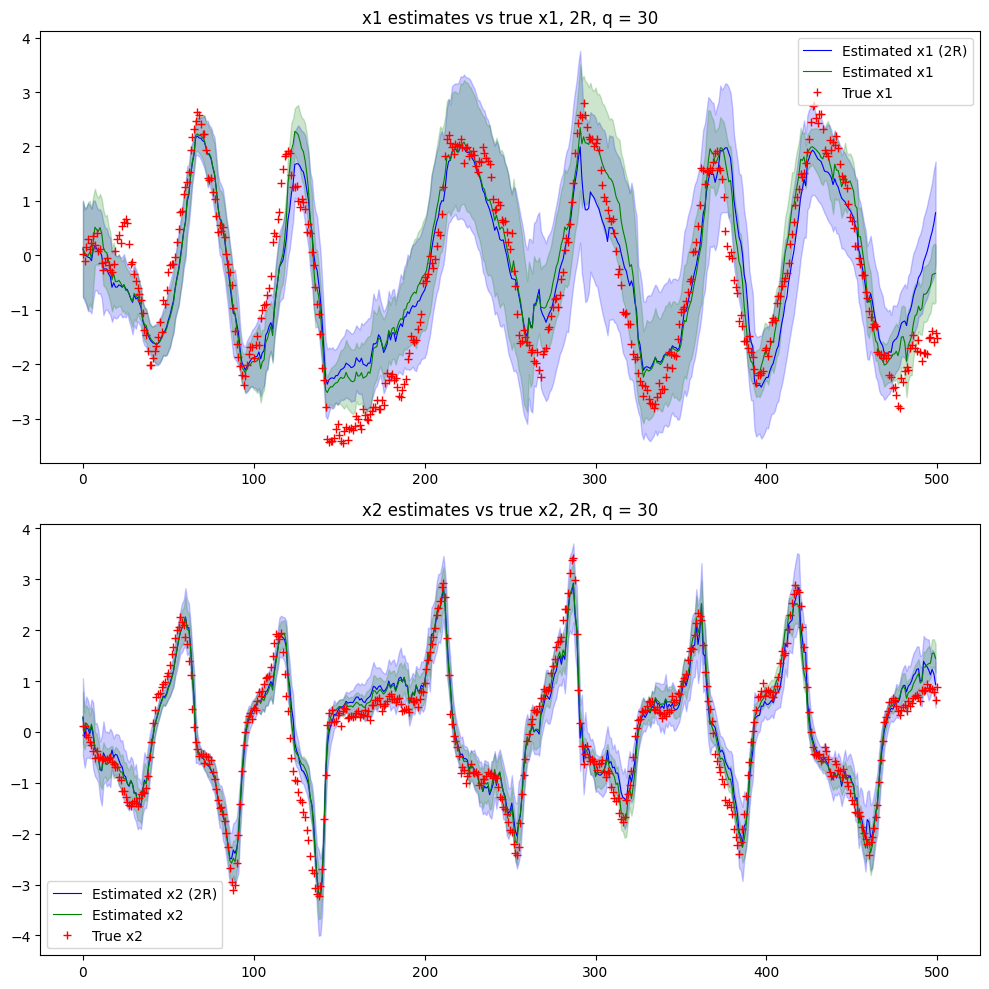

Coverage probability x1: 0.65
Coverage probability x2: 0.66
Coverage probability x1 (2R): 0.74
Coverage probability x2 (2R): 0.78


In [264]:
# For 2R
MSE_x1_two = np.mean((np.array(result_x1_two) - true_states[1:, 0])**2)
MSE_x2_two = np.mean((np.array(result_x2_two) - true_states[1:, 1])**2)
print(f"MSE x1 (2R): {MSE_x1_two:.2}")
print(f"MSE x2 (2R): {MSE_x2_two:.2}")

# For R
MSE_x1 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
MSE_x2 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
print(f"MSE x1: {MSE_x1:.2}")
print(f"MSE x2: {MSE_x2:.2}")

# Confidence intervals
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_two, linestyle='-', linewidth=0.8, label="Estimated x1 (2R)", color='blue')
axs[0].plot(result_x1_30, linestyle='-', linewidth=0.8, label="Estimated x1", color='g')
axs[0].plot(true_states[:, 0], linestyle='None', marker='+', label="True x1", color="r")
axs[0].fill_between(range(T), np.array(result_x1_two) - np.array(var_x1_30_two), np.array(result_x1_two) + np.array(var_x1_30_two), alpha=0.2, color='blue')
axs[0].fill_between(range(T), np.array(result_x1_30) - np.array(var_x1_30), np.array(result_x1_30) + np.array(var_x1_30), alpha=0.2, color='g')
axs[0].set_title("x1 estimates vs true x1, 2R, q = " + str(ensemble_size))
axs[0].legend()

axs[1].plot(result_x2_two, linestyle='-', linewidth=0.8, label="Estimated x2 (2R)", color='blue')
axs[1].plot(result_x2_30, linestyle='-', linewidth=0.8, label="Estimated x2", color='g')
axs[1].plot(true_states[:, 1], linestyle='None', marker='+', label="True x2", color="r")
axs[1].fill_between(range(T), np.array(result_x2_two) - np.array(var_x2_30_two), np.array(result_x2_two) + np.array(var_x2_30_two), alpha=0.2, color='blue')
axs[1].fill_between(range(T), np.array(result_x2_30) - np.array(var_x2_30), np.array(result_x2_30) + np.array(var_x2_30), alpha=0.2, color='g')
axs[1].set_title("x2 estimates vs true x2, 2R, q = " + str(ensemble_size))
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("EnKF_confidence_intervals.png")
plt.show()

# Coverage probability
coverage_x1 = 0
coverage_x2 = 0
for i in range(T):
    if true_states[i, 0] >= result_x1_30[i] - var_x1_30[i] and true_states[i, 0] <= result_x1_30[i] + var_x1_30[i]:
        coverage_x1 += 1
    if true_states[i, 1] >= result_x2_30[i] - var_x2_30[i] and true_states[i, 1] <= result_x2_30[i] + var_x2_30[i]:
        coverage_x2 += 1
coverage_x1 /= T
coverage_x2 /= T
print(f"Coverage probability x1: {coverage_x1:.2}")
print(f"Coverage probability x2: {coverage_x2:.2}")

# For 2R
coverage_x1_two = 0
coverage_x2_two = 0
for i in range(T):
    if true_states[i, 0] >= result_x1_two[i] - var_x1_30_two[i] and true_states[i, 0] <= result_x1_two[i] + var_x1_30_two[i]:
        coverage_x1_two += 1
    if true_states[i, 1] >= result_x2_two[i] - var_x2_30_two[i] and true_states[i, 1] <= result_x2_two[i] + var_x2_30_two[i]:
        coverage_x2_two += 1
coverage_x1_two /= T
coverage_x2_two /= T
print(f"Coverage probability x1 (2R): {coverage_x1_two:.2}")
print(f"Coverage probability x2 (2R): {coverage_x2_two:.2}")




We note that both cases capture the trend well. But the MSEs in the $2R$ case is slightly larger than that of the $R$ case. We also noticed that the intervals for $2R$ are wider and capture the true states better.

## Variance inflation

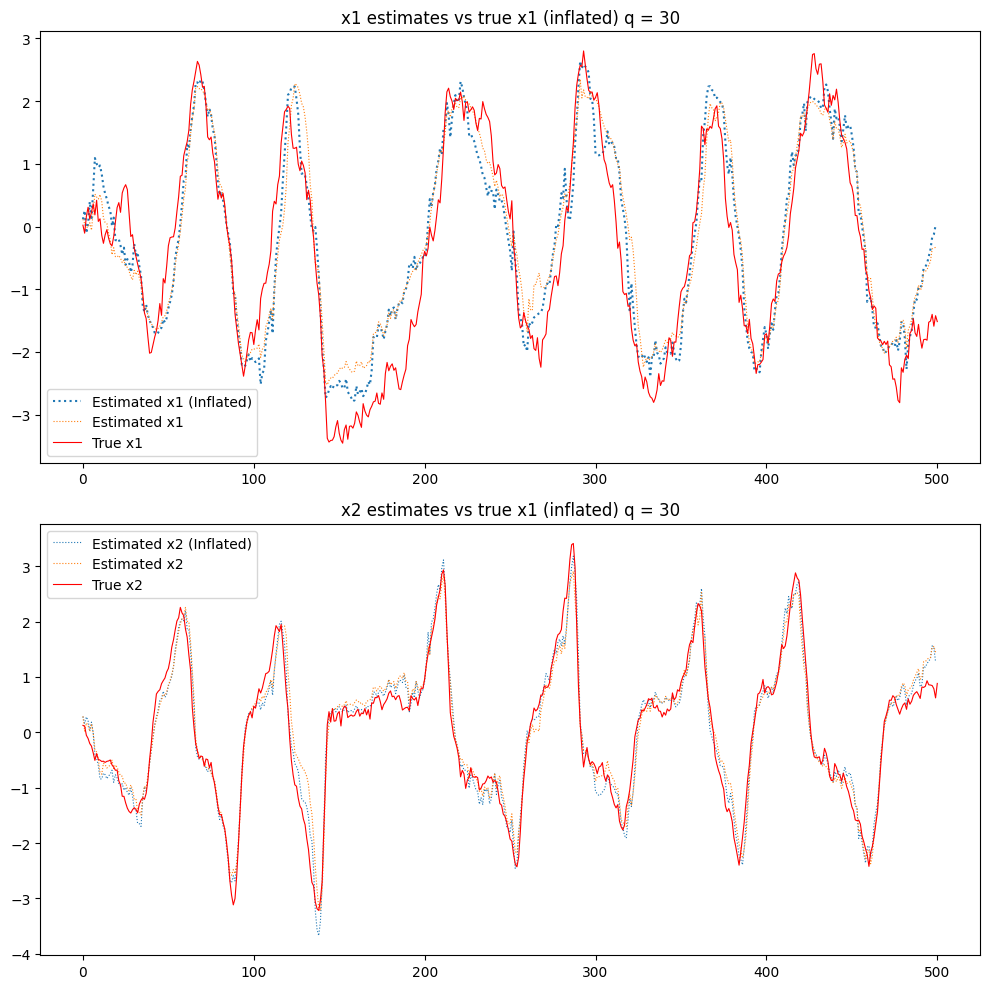

MSE x1 (Inflated): 0.42
MSE x2 (Inflated): 0.14
MSE x1: 0.5
MSE x2: 0.18


In [265]:
np.random.seed(999)
ensemble_size = 30
inflation = 2 # alpha
R2 = R/inflation**2

# Instantiate and initialize EnKF
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R2, Q)
enkf.initialize_ensemble(initial_state)

result_x1Inf = []
result_x2Inf = []
var_x1_30Inf = []
var_x2_30Inf = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1Inf.append(enkf.get_state_estimate()[0])
  result_x2Inf.append(enkf.get_state_estimate()[1])
  var_x1_30Inf.append(enkf.get_variance_estimate()[0])
  var_x2_30Inf.append(enkf.get_variance_estimate()[1])

# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1Inf, linestyle=':', label="Estimated x1 (Inflated)")
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1", color="red")
axs[0].set_title("x1 estimates vs true x1 (inflated) q = " + str(ensemble_size ))
axs[0].legend()

axs[1].plot(result_x2Inf, linestyle=':', linewidth=0.8, label="Estimated x2 (Inflated)")
axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2", color="red")
axs[1].set_title("x2 estimates vs true x1 (inflated) q = " + str(ensemble_size ))
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

MSE_x1Inf = np.mean((np.array(result_x1Inf) - true_states[1:, 0])**2)
MSE_x2Inf = np.mean((np.array(result_x2Inf) - true_states[1:, 1])**2)
print(f"MSE x1 (Inflated): {MSE_x1Inf:.2}")
print(f"MSE x2 (Inflated): {MSE_x2Inf:.2}")

MSE_x1_30 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
MSE_x2_30 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
print(f"MSE x1: {MSE_x1_30:.2}")
print(f"MSE x2: {MSE_x2_30:.2}")


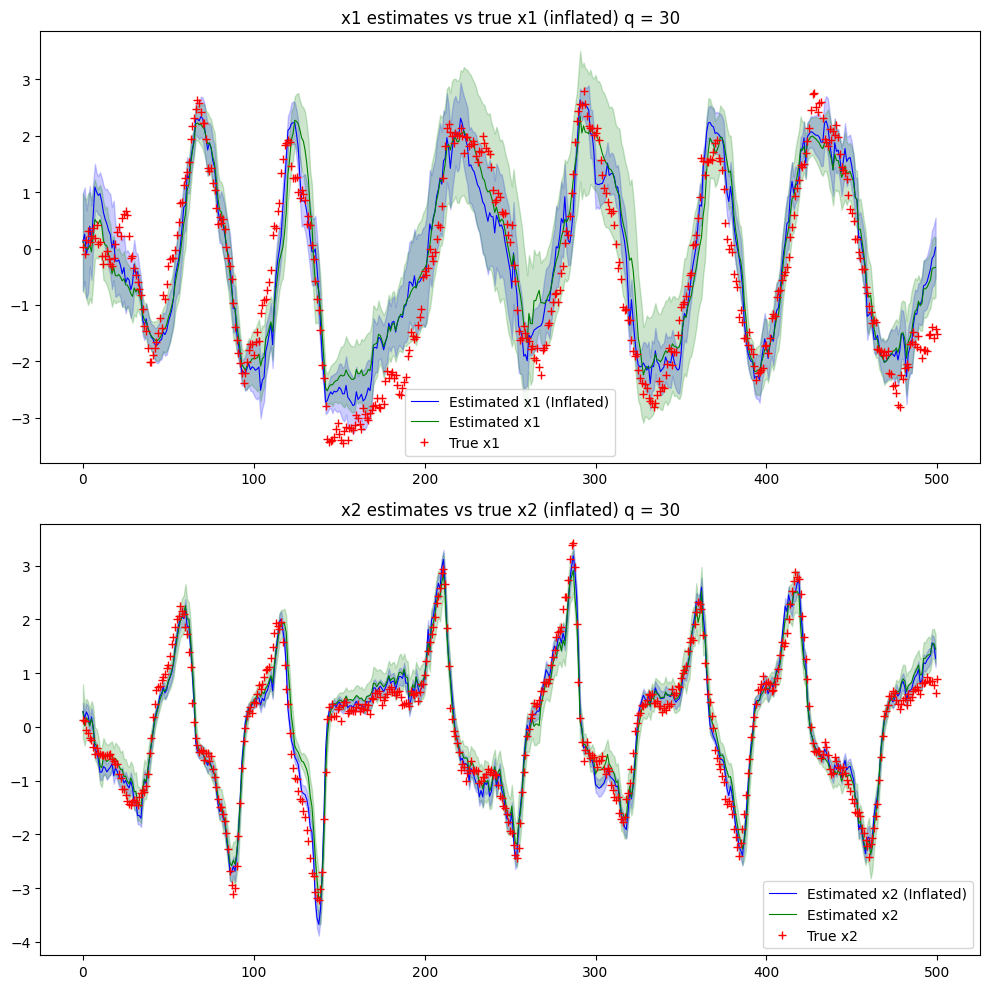

Coverage probability x1 (Inflated): 0.55
Coverage probability x2 (Inflated): 0.44
Coverage probability x1: 0.65
Coverage probability x2: 0.66
Coverage probability x1 (2R): 0.74
Coverage probability x2 (2R): 0.78
MSE x1 (Inflated): 0.42
MSE x2 (Inflated): 0.14
MSE x1: 0.5
MSE x2: 0.18
MSE x1 (2R): 0.62
MSE x2 (2R): 0.21


In [266]:
# Confidence intervals
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1Inf, linestyle='-', linewidth=0.8, label="Estimated x1 (Inflated)", color='blue')
axs[0].plot(result_x1_30, linestyle='-', linewidth=0.8, label="Estimated x1", color='g')
axs[0].plot(true_states[:, 0], linestyle='None', marker='+', label="True x1", color="r")
axs[0].fill_between(range(T), np.array(result_x1Inf) - np.array(var_x1_30Inf), np.array(result_x1Inf) + np.array(var_x1_30Inf), alpha=0.2, color='blue')
axs[0].fill_between(range(T), np.array(result_x1_30) - np.array(var_x1_30), np.array(result_x1_30) + np.array(var_x1_30), alpha=0.2, color='g')
axs[0].set_title("x1 estimates vs true x1 (inflated) q = " + str(ensemble_size))
axs[0].legend()

axs[1].plot(result_x2Inf, linestyle='-', linewidth=0.8, label="Estimated x2 (Inflated)", color='blue')
axs[1].plot(result_x2_30, linestyle='-', linewidth=0.8, label="Estimated x2", color='g')
axs[1].plot(true_states[:, 1], linestyle='None', marker='+', label="True x2", color="r")
axs[1].fill_between(range(T), np.array(result_x2Inf) - np.array(var_x2_30Inf), np.array(result_x2Inf) + np.array(var_x2_30Inf), alpha=0.2, color='blue')
axs[1].fill_between(range(T), np.array(result_x2_30) - np.array(var_x2_30), np.array(result_x2_30) + np.array(var_x2_30), alpha=0.2, color='g')
axs[1].set_title("x2 estimates vs true x2 (inflated) q = " + str(ensemble_size))
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("EnKF_confidence_intervals_inflated.png")
plt.show()

# Coverage probability
coverage_x1Inf = 0
coverage_x2Inf = 0

for i in range(T):
    if true_states[i, 0] >= result_x1Inf[i] - var_x1_30Inf[i] and true_states[i, 0] <= result_x1Inf[i] + var_x1_30Inf[i]:
        coverage_x1Inf += 1
    if true_states[i, 1] >= result_x2Inf[i] - var_x2_30Inf[i] and true_states[i, 1] <= result_x2Inf[i] + var_x2_30Inf[i]:
        coverage_x2Inf += 1
coverage_x1Inf /= T
coverage_x2Inf /= T

print(f"Coverage probability x1 (Inflated): {coverage_x1Inf:.2}")
print(f"Coverage probability x2 (Inflated): {coverage_x2Inf:.2}")
print(f"Coverage probability x1: {coverage_x1:.2}")
print(f"Coverage probability x2: {coverage_x2:.2}")
print(f"Coverage probability x1 (2R): {coverage_x1_two:.2}")
print(f"Coverage probability x2 (2R): {coverage_x2_two:.2}")

print(f"MSE x1 (Inflated): {MSE_x1Inf:.2}")
print(f"MSE x2 (Inflated): {MSE_x2Inf:.2}")
print(f"MSE x1: {MSE_x1_30:.2}")
print(f"MSE x2: {MSE_x2_30:.2}")
print(f"MSE x1 (2R): {MSE_x1_two:.2}")
print(f"MSE x2 (2R): {MSE_x2_two:.2}")


# Example 2. Ornstein-Uhlenbeck model from sarkka2019applied example 10.19
Linear and low dimension case. \\

**Example 10.19 (Kalman filter for the Ornstein-Uhlenbeck model).** Recall from Example 6.2 that the equivalent discretization of the OrnsteinUhlenbeck model is

$$
\begin{aligned}
x\left(t_{k+1}\right) & =a_k x\left(t_k\right)+q_k, \\
y_k & =x\left(t_k\right)+r_k,
\end{aligned}
$$

with $q_k \sim \mathrm{~N}\left(0, \Sigma_k\right), r_k \sim \mathrm{~N}(0, R), a_k=\exp \left(-\lambda \Delta t_k\right)$, and $\Sigma_k=\frac{q}{2 \lambda}[1-$ $\left.\exp \left(-2 \lambda \Delta t_k\right)\right]$. \\

Redefine an EnKF class as `EnsembleKalmanFilter_onedim` due to the dimension issue in `numpy`.

Kalman Filter MSE: 0.062
Ensemble Kalman Filter MSE: 0.073
Ensemble Kalman Filter with R=2R MSE: 0.068
Ensemble Kalman Filter with Inflation MSE: 0.063


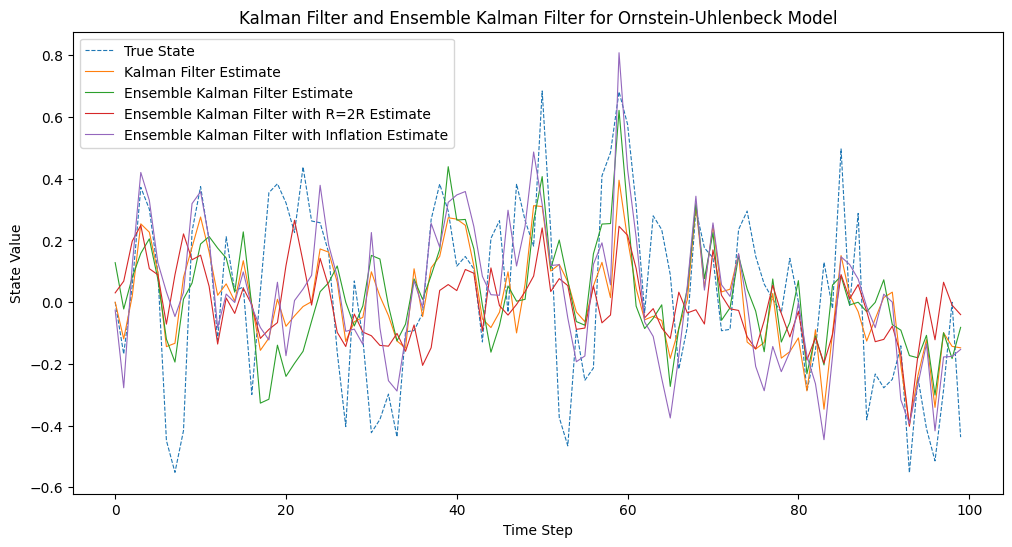

0.08328713300134209
0.02345739213196012
0.027906270552953437
0.013709383850868919
0.04872567891027996


In [267]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(456)

class KalmanFilter:
    def __init__(self, lambda_, q, R, initial_mean, initial_variance, dt):
        self.lambda_ = lambda_
        self.q = q
        self.R = R
        self.m_k = initial_mean
        self.P_k = initial_variance
        self.dt = dt

    def predict(self):
        a_k = np.exp(-self.lambda_ * self.dt)
        self.m_k_minus = a_k * self.m_k
        self.P_k_minus = np.exp(-2 * self.lambda_ * self.dt) * self.P_k + (self.q / (2 * self.lambda_)) * (1 - np.exp(-2 * self.lambda_ * self.dt))

    def update(self, y_k):
        K_k = self.P_k_minus / (self.P_k_minus + self.R)
        self.m_k = self.m_k_minus + K_k * (y_k - self.m_k_minus)
        self.P_k = self.P_k_minus - (K_k ** 2) * (self.P_k_minus + self.R)

    def get_state_estimate(self):
        return self.m_k

class EnsembleKalmanFilter_onedim:
    '''
    x and y are one dim
    '''
    def __init__(self, ensemble_size, state_dim, process_model, observation_model, R, Q):
        self.ensemble_size = ensemble_size
        self.state_dim = state_dim
        self.process_model = process_model
        self.observation_model = observation_model
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.ensemble = None

    def initialize_ensemble(self, initial_state, spread=1.0):
       self.ensemble = np.array([initial_state + spread * np.random.randn() for _ in range(self.ensemble_size)])


    def predict(self):
        for i in range(self.ensemble_size):
            if np.isscalar(observation):
                process_noise = np.random.normal(0, np.sqrt(self.Q))
            self.ensemble[i] = self.process_model(self.ensemble[i]) + process_noise

    def update(self, observation):
        ensemble_mean = np.mean(self.ensemble, axis=0)
        ensemble_observations = np.array([self.observation_model(member) for member in self.ensemble])
        observation_mean = np.mean(ensemble_observations, axis=0)
        P_yy = np.var(ensemble_observations) + self.R
        P_xy = np.cov(self.ensemble, ensemble_observations, bias=True)[0, 1]
        K = P_xy / P_yy

        for i in range(self.ensemble_size):
            innovation = observation + np.random.normal(0, np.sqrt(self.R)) - ensemble_observations[i]
            self.ensemble[i] += K * innovation

    def get_state_estimate(self):
        return np.mean(self.ensemble, axis=0)

# Define parameters for Ornstein-Uhlenbeck process
lambda_ = 0.5
q = 0.1
R = 0.5
initial_mean = 0.0
initial_variance = 1.0
num_steps = 100
dt = 1.0
ensemble_size = 10

# Generate synthetic observations
a_k = np.exp(-lambda_ * dt)
Sigma_k = (q / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * dt))
y = [initial_mean]
true_state = [initial_mean]
for _ in range(1, num_steps):
    process_noise = np.random.normal(0, np.sqrt(Sigma_k))
    next_state = a_k * true_state[-1] + process_noise
    observation_noise = np.random.normal(0, np.sqrt(R))
    observation = next_state + observation_noise
    true_state.append(next_state)
    y.append(observation)

# Apply the Kalman Filter
kf = KalmanFilter(lambda_, q, R, initial_mean, initial_variance, dt)
kf_state_estimates = []
for observation in y:
    kf.predict()
    kf.update(observation)
    kf_state_estimates.append(kf.get_state_estimate())


# Apply the Ensemble Kalman Filter
enkf = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x, R=R, Q=Sigma_k)
enkf.initialize_ensemble(initial_mean)
enkf_state_estimates = []
for observation in y:
    enkf.predict()
    enkf.update(observation)
    enkf_state_estimates.append(enkf.get_state_estimate())

# Apply the Ensemble Kalman Filter with R = 2R
R_2 = 2 * R
enkf_2R = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x,R=R_2, Q=Sigma_k)
enkf_2R.initialize_ensemble(initial_mean)
enkf_2R_state_estimates = []
for observation in y:
    enkf_2R.predict()
    enkf_2R.update(observation)
    enkf_2R_state_estimates.append(enkf_2R.get_state_estimate())

# Apply inflation
inflation = 1.2
R_inf = R / (inflation ** 2)
enkf_inf = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x, R=R_inf, Q=Sigma_k)
enkf_inf.initialize_ensemble(initial_mean)
enkf_inf_state_estimates = []
for observation in y:
    enkf_inf.predict()
    enkf_inf.update(observation)
    enkf_inf_state_estimates.append(enkf_inf.get_state_estimate())

# Compute Mean Squared Errors (MSE)
def compute_mse(true_values, estimated_values):
    return np.mean((np.array(true_values) - np.array(estimated_values)) ** 2)

kf_mse = compute_mse(true_state, kf_state_estimates)
enkf_mse = compute_mse(true_state, enkf_state_estimates)
enkf_2R_mse = compute_mse(true_state, enkf_2R_state_estimates)
enkf_inf_mse = compute_mse(true_state, enkf_inf_state_estimates)

print(f"Kalman Filter MSE: {kf_mse:.2}")
print(f"Ensemble Kalman Filter MSE: {enkf_mse:.2}")
print(f"Ensemble Kalman Filter with R=2R MSE: {enkf_2R_mse:.2}")
print(f"Ensemble Kalman Filter with Inflation MSE: {enkf_inf_mse:.2}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(num_steps), true_state, linewidth=0.8, label='True State', linestyle='--')
plt.plot(range(num_steps), kf_state_estimates, linewidth=0.8, label='Kalman Filter Estimate')
plt.plot(range(num_steps), enkf_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter Estimate')
plt.plot(range(num_steps), enkf_2R_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter with R=2R Estimate')
plt.plot(range(num_steps), enkf_inf_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter with Inflation Estimate')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter and Ensemble Kalman Filter for Ornstein-Uhlenbeck Model')
plt.legend()
plt.show()

print(np.var(true_state))
print(np.var(kf_state_estimates))
print(np.var(enkf_state_estimates))
print(np.var(enkf_2R_state_estimates))
print(np.var(enkf_inf_state_estimates))

# Example 3: Lorenz-96 from zhang2021langevinized

## Define the Lorenz-96 model solved by RK4.


In [268]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Lorenz 96 model with constant forcing
def lorenz96(x, F=8):
    """Lorenz 96 model with constant forcing."""
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
            if i == 0:
                dxdt[i] = (x[1] -x[N-2]) * x[N-1] - x[i] + F
            elif i == 1:
                dxdt[i] = (x[i+1] - x[N-1]) * x[0] - x[i] + F
            elif i == N - 1:
                dxdt[i] = (x[0] - x[i-2]) * x[i-1] - x[i] + F
            else:
                dxdt[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

# RK4 integration step function
def rk4_step(func, x, dt, *args):
    """Runge-Kutta 4th order integration step."""
    k1 = dt * func(x, *args)
    k2 = dt * func(x + 0.5 * k1, *args)
    k3 = dt * func(x + 0.5 * k2, *args)
    k4 = dt * func(x + k3, *args)
    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


## Generate data, set parameters as in the paper


In [269]:
np.random.seed(999)

# Parameters
state_dim = 40          # State dimension for Lorenz 96
obs_dim = 20            # Number of observations (half of the state is observed)
num_ensemble = 50       # Number of ensemble members
timesteps = 100         # Number of timesteps
dt = 0.01               # Timestep size
obs_noise_std = 1.0     # Standard deviation of observation noise
process_noise_std = 1.0   # Standard deviation of process noise

# Initial state
x0 = np.random.rand(state_dim) + 20  # Initial true state
x0[19] = 20.01

# Observation matrix: randomly select observed state variables
H = np.zeros((obs_dim, state_dim))
obs_indices = np.random.choice(state_dim, obs_dim, replace=False)
for i, idx in enumerate(obs_indices):
    H[i, idx] = 1

# Generate true states and observations
true_states = [x0]
observations = []

# Integrate the true state forward and generate observations
for t in range(timesteps):
    process_noise = np.random.normal(0, process_noise_std, state_dim)
    true_state = rk4_step(lorenz96, true_states[-1], dt, 8) + process_noise
    obs = H @ true_state + np.random.normal(0, obs_noise_std, obs_dim)
    true_states.append(true_state)
    observations.append(obs)

# Convert lists to numpy arrays
true_states = np.array(true_states)
observations = np.array(observations)

## Implement EnKF
First define a function for EnKF.

In [270]:
# Function for the EnKF
def EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation): 
    # Create two lists to store the estimated states and ensemble standard deviations
    estimated_states = []
    ensemble_std_dev = []
    ensemble_mean = np.mean(ensemble, axis=0)
    estimated_states.append(ensemble_mean)
    ensemble_std_dev.append(np.std(ensemble, axis=0))

    for t in range(timesteps):
        # Forecast Step: propagate each ensemble member
        for i in range(num_ensemble):
            process_noise = np.random.normal(0, process_noise_std, state_dim)
            ensemble[i] = rk4_step(lorenz96, ensemble[i], dt, 8) + process_noise

        # Calculate ensemble mean and deviations
        ensemble_mean = np.mean(ensemble, axis=0)
        deviations = ensemble - ensemble_mean
        
        # Calculate observation ensemble and deviations
        obs_ensemble = H @ ensemble.T  # Shape: (obs_dim, num_ensemble)
        obs_ensemble_mean = np.mean(obs_ensemble, axis=1)
        obs_deviations = obs_ensemble - obs_ensemble_mean[:, None]

        # Calculate cross-covariance P_xy
        P_xy = inflation * (deviations.T @ obs_deviations.T) / (num_ensemble - 1)  # Shape: (state_dim, obs_dim)

        # Calculate observation covariance P_yy
        P_yy = inflation * (obs_deviations @ obs_deviations.T) / (num_ensemble - 1) + np.eye(obs_dim) * obs_noise_std**2

        # Calculate Kalman Gain
        K = P_xy @ np.linalg.inv(P_yy)

        # Analysis Step: update each ensemble member with observation
        for i in range(num_ensemble):
            observation_noise = np.random.normal(0, obs_noise_std, obs_dim)
            ensemble[i] += K @ (observations[t] + observation_noise - H @ ensemble[i])

        # Store estimated mean state
        ensemble_mean = np.mean(ensemble, axis=0)
        estimated_states.append(ensemble_mean)
        
        # Store the standard deviation of the ensemble for confidence interval calculation
        ensemble_std_dev.append(np.std(ensemble, axis=0))
    return estimated_states, ensemble_std_dev

## Plain EnKF implementation 

In [271]:
np.random.seed(999)

# Run the EnKF
# Generate ensemble members around the initial state
P_init = np.eye(state_dim) * 1.0
ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

# Run the EnKF for state estimation
estimated_states, ensemble_std_dev = EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation=1.0)

# Convert estimated states and standard deviation to numpy arrays
estimated_states = np.array(estimated_states)
ensemble_std_dev = np.array(ensemble_std_dev)

# Calculate 95% confidence intervals (mean ± 1.96 * std deviation)
confidence_interval_upper = estimated_states + 1.96 * ensemble_std_dev
confidence_interval_lower = estimated_states - 1.96 * ensemble_std_dev

## Implement EnKF with variance inflation

In [272]:
np.random.seed(999)

# Implement EnKF with inlfation
P_init = np.eye(state_dim) * 1.0
ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

# Run the EnKF for state estimation
estimated_states_inflated, ensemble_std_dev_inflated = EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation = 2)

# Convert estimated states and standard deviation to numpy arrays
estimated_states_inflated = np.array(estimated_states_inflated)
ensemble_std_dev_inflated = np.array(ensemble_std_dev_inflated)

# Calculate 95% confidence intervals (mean ± 1.96 * std deviation)
confidence_interval_upper_inflated = estimated_states_inflated + 1.96 * ensemble_std_dev_inflated
confidence_interval_lower_inflated = estimated_states_inflated - 1.96 * ensemble_std_dev_inflated


## Implement EnKF with $R = 2R$

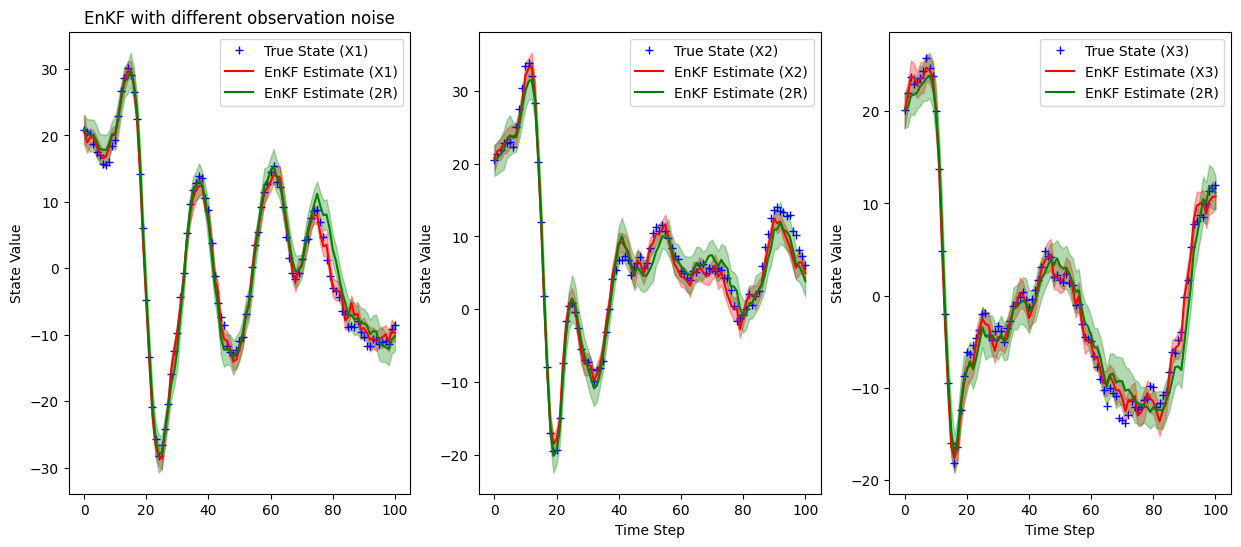

EnKF MSE: 4.4e+01
EnKF with 2R MSE: 3.1e+01


In [273]:
R2 = 2 * obs_noise_std
# Implement EnKF with R = 2R
P_init = np.eye(state_dim) * 1.0
ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

# Run the EnKF for state estimation
estimated_states_2R, ensemble_std_dev_2R = EnKF(ensemble, observations, H, process_noise_std, R2, num_ensemble, timesteps, dt, inflation=1.0)

# Convert estimated states and standard deviation to numpy arrays
estimated_states_2R = np.array(estimated_states_2R)
ensemble_std_dev_2R = np.array(ensemble_std_dev_2R)

# Calculate 95% confidence intervals (mean ± 1.96 * std deviation)
confidence_interval_upper_2R = estimated_states_2R + 1.96 * ensemble_std_dev_2R
confidence_interval_lower_2R = estimated_states_2R - 1.96 * ensemble_std_dev_2R

# Plot the results
fig = plt.figure(figsize=(15, 6))
grid = plt.GridSpec(1, 3, hspace=0.3)
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(range(timesteps + 1), true_states[:, 0], label='True State (X1)', marker='+', color='b', linestyle='None')
ax1.plot(range(timesteps + 1), estimated_states[:, 0], label='EnKF Estimate (X1)', color='r')
ax1.fill_between(range(timesteps + 1), confidence_interval_lower[:, 0], confidence_interval_upper[:, 0], color='r', alpha=0.3)
ax1.plot(range(timesteps + 1), estimated_states_2R[:, 0], label='EnKF Estimate (2R)', color='green')
ax1.fill_between(range(timesteps + 1), confidence_interval_lower_2R[:, 0], confidence_interval_upper_2R[:, 0], color='green', alpha=0.3)
ax1.set_ylabel('State Value')
ax1.set_title('EnKF with different observation noise')
ax1.legend()    

ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(range(timesteps + 1), true_states[:, 1], label='True State (X2)', marker='+', color='b', linestyle='None')
ax2.plot(range(timesteps + 1), estimated_states[:, 1], label='EnKF Estimate (X2)', color='r')
ax2.fill_between(range(timesteps + 1), confidence_interval_lower[:, 1], confidence_interval_upper[:, 1], color='r', alpha=0.3)
ax2.plot(range(timesteps + 1), estimated_states_2R[:, 1], label='EnKF Estimate (2R)', color='green')
ax2.fill_between(range(timesteps + 1), confidence_interval_lower_2R[:, 1], confidence_interval_upper_2R[:, 1], color='green', alpha=0.3)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('State Value')
ax2.legend()

ax3 = fig.add_subplot(grid[0, 2])
ax3.plot(range(timesteps + 1), true_states[:, 2], label='True State (X3)', marker='+', color='b', linestyle='None')
ax3.plot(range(timesteps + 1), estimated_states[:, 2], label='EnKF Estimate (X3)', color='r')
ax3.fill_between(range(timesteps + 1), confidence_interval_lower[:, 2], confidence_interval_upper[:, 2], color='r', alpha=0.3)
ax3.plot(range(timesteps + 1), estimated_states_2R[:, 2], label='EnKF Estimate (2R)', color='green')
ax3.fill_between(range(timesteps + 1), confidence_interval_lower_2R[:, 2], confidence_interval_upper_2R[:, 2], color='green', alpha=0.3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('State Value')
ax3.legend()

plt.show()

# Calculate MSE
def compute_mse(true_values, estimated_values):
    return np.mean((true_values - estimated_values) ** 2)

mse = compute_mse(true_states, estimated_states)
mse_2R = compute_mse(true_states, estimated_states_2R)
print(f"EnKF MSE: {mse:.2}")
print(f"EnKF with 2R MSE: {mse_2R:.2}")



## Plot the results


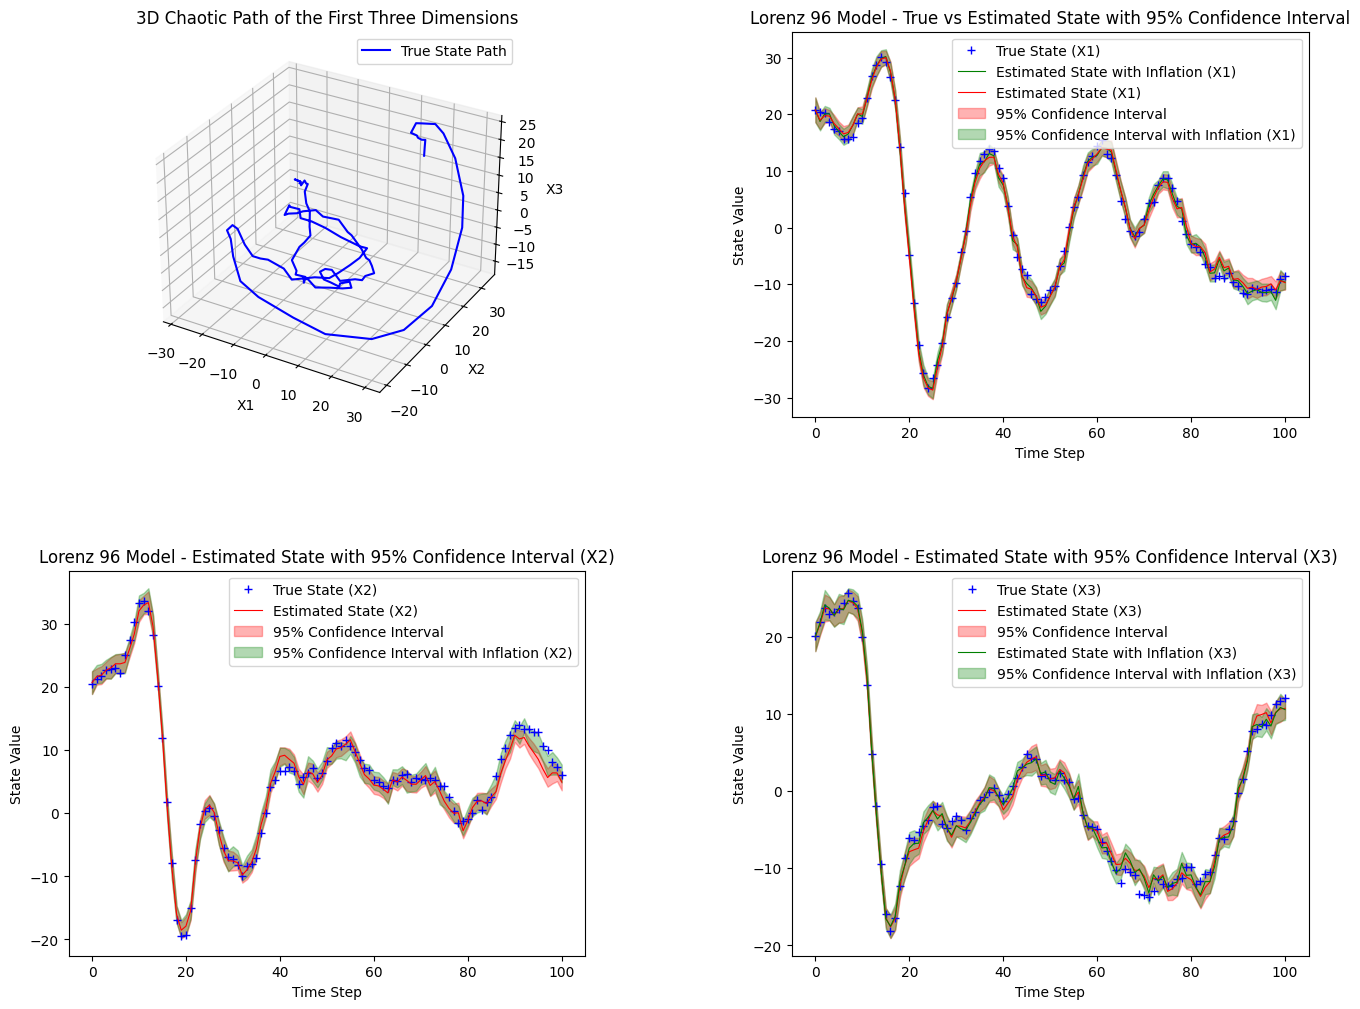

In [274]:
# Plotting
fig = plt.figure(figsize=(16, 12))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.4)

# 3D plot of the first three dimensions
ax1 = fig.add_subplot(grid[0, 0], projection='3d')
ax1.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True State Path', color='b')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('3D Chaotic Path of the First Three Dimensions')
ax1.legend()

# Plotting true state vs estimated state with confidence interval for the first dimension
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(range(timesteps + 1), true_states[:, 0], label='True State (X1)', color='b', marker='+', linestyle='None')
ax2.plot(range(timesteps + 1), estimated_states_inflated[:, 0], linestyle='-', label='Estimated State with Inflation (X1)', color='g', linewidth=0.8)
ax2.plot(range(timesteps + 1), estimated_states[:, 0], linestyle='-', label='Estimated State (X1)', color='r', linewidth=0.8)
ax2.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 0],
                 confidence_interval_upper[:, 0],
                 color='r', alpha=0.3, label='95% Confidence Interval')
ax2.fill_between(range(timesteps + 1),
                 confidence_interval_lower_inflated[:, 0],
                 confidence_interval_upper_inflated[:, 0],
                 color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X1)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('State Value')
ax2.set_title('Lorenz 96 Model - True vs Estimated State with 95% Confidence Interval')
ax2.legend()

# Plotting estimated state for other dimensions in the 2x2 grid
ax3 = fig.add_subplot(grid[1, 0])
ax3.plot(range(timesteps + 1), true_states[:, 1], label='True State (X2)', color='b', marker='+', linestyle='None')
ax3.plot(range(timesteps + 1), estimated_states[:, 1], linestyle='-', label='Estimated State (X2)', color='r', linewidth=0.8)
ax3.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 1],
                 confidence_interval_upper[:, 1],
                 color='r', alpha=0.3, label='95% Confidence Interval')

ax3.fill_between(range(timesteps + 1),
                    confidence_interval_lower_inflated[:, 1],
                    confidence_interval_upper_inflated[:, 1],
                    color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X2)')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('State Value')
ax3.set_title('Lorenz 96 Model - Estimated State with 95% Confidence Interval (X2)')
ax3.legend()

ax4 = fig.add_subplot(grid[1, 1])
ax4.plot(range(timesteps + 1), true_states[:, 2], label='True State (X3)', color='b', marker='+', linestyle='None')
ax4.plot(range(timesteps + 1), estimated_states[:, 2], linestyle='-', label='Estimated State (X3)', color='r', linewidth=0.8)
ax4.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 2],
                 confidence_interval_upper[:, 2],
                 color='r', alpha=0.3, label='95% Confidence Interval')
ax4.plot(range(timesteps + 1), estimated_states_inflated[:, 2], linestyle='-', label='Estimated State with Inflation (X3)', color='g', linewidth=0.8)
ax4.fill_between(range(timesteps + 1),
                 confidence_interval_lower_inflated[:, 2],
                 confidence_interval_upper_inflated[:, 2],
                 color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X3)')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('State Value')
ax4.set_title('Lorenz 96 Model - Estimated State with 95% Confidence Interval (X3)')
ax4.legend()

plt.show()


## Compute the covarage probability over time

Coverage Probability for each state dimension:
EnKF: [0.76237624 0.76237624 0.86138614 0.42574257]
EnKF with Inflation: [0.84158416 0.87128713 0.86138614 0.37623762]
EnKF with 2R: [0.83168317 0.77227723 0.8019802  0.34653465]


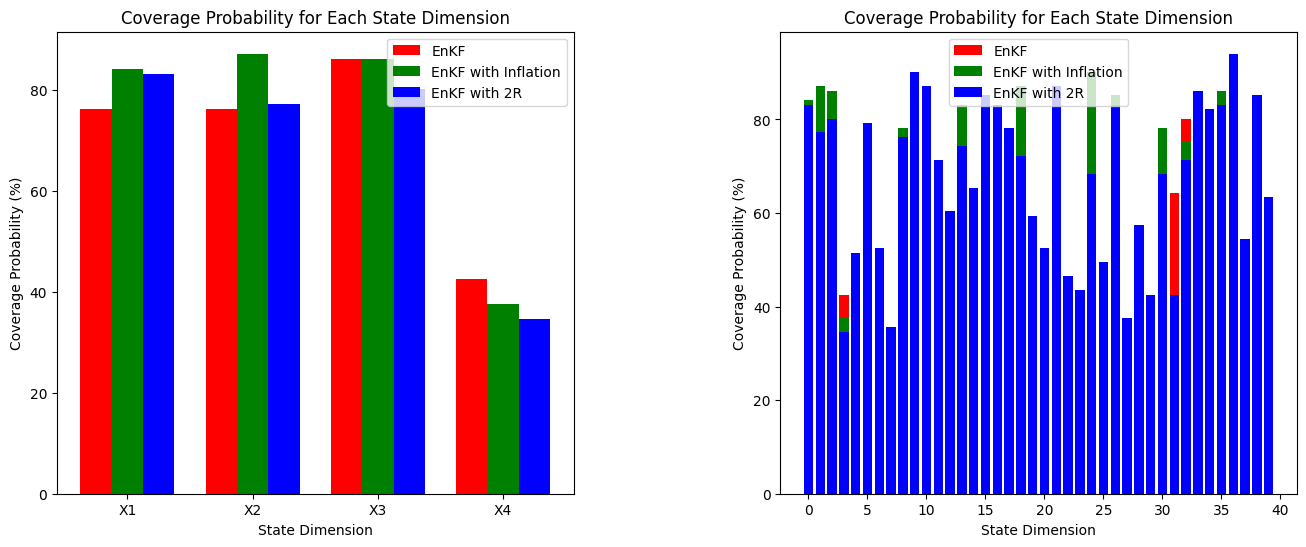

In [275]:
# Coverage probability for each state dimension
# At each time, if a state dimension is covered by the confidence interval, increment the coverage count for that dimension
# Divide the coverage count by the total number of timesteps to get the coverage probability

def compute_coverage_probability(true_states, estimated_states, confidence_interval_lower, confidence_interval_upper):
    coverage_probability = np.zeros(true_states.shape[1])
    for t in range(timesteps + 1):
        for i in range(true_states.shape[1]):
            if true_states[t, i] >= confidence_interval_lower[t, i] and true_states[t, i] <= confidence_interval_upper[t, i]:
                coverage_probability[i] += 1
    return coverage_probability / (timesteps + 1)

coverage_probability = compute_coverage_probability(true_states, estimated_states, confidence_interval_lower, confidence_interval_upper)
coverage_probability_inflated = compute_coverage_probability(true_states, estimated_states_inflated, confidence_interval_lower_inflated, confidence_interval_upper_inflated)
coverage_probability_2R = compute_coverage_probability(true_states, estimated_states_2R, confidence_interval_lower_2R, confidence_interval_upper_2R)

print(f"Coverage Probability for each state dimension:")
print(f"EnKF: {coverage_probability[0:4]}")
print(f"EnKF with Inflation: {coverage_probability_inflated[0:4]}")
print(f"EnKF with 2R: {coverage_probability_2R[0:4]}")

# Convert to percentage
coverage_probability = coverage_probability * 100
coverage_probability_inflated = coverage_probability_inflated * 100
coverage_probability_2R = coverage_probability_2R * 100

# Plot the coverage probability for each state dimension
# side-by-side bar plot and separate bar plot for each state dimension
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(1, 2, wspace=0.4)

ax1 = fig.add_subplot(grid[0])
bar_width = 0.25
bar_positions = np.arange(4)
ax1.bar(bar_positions, coverage_probability[0:4], bar_width, label='EnKF', color='r')
ax1.bar(bar_positions + bar_width, coverage_probability_inflated[0:4], bar_width, label='EnKF with Inflation', color='g')
ax1.bar(bar_positions + 2 * bar_width, coverage_probability_2R[0:4], bar_width, label='EnKF with 2R', color='b')
ax1.set_xlabel('State Dimension')
ax1.set_ylabel('Coverage Probability (%)')
ax1.set_title('Coverage Probability for Each State Dimension')
ax1.set_xticks(bar_positions + bar_width)
ax1.set_xticklabels(['X1', 'X2', 'X3', 'X4'])
ax1.legend()

ax2 = fig.add_subplot(grid[1])
bar_positions = np.arange(40)
ax2.bar(bar_positions, coverage_probability, label='EnKF', color='r')
ax2.bar(bar_positions, coverage_probability_inflated, label='EnKF with Inflation', color='g')
ax2.bar(bar_positions, coverage_probability_2R, label='EnKF with 2R', color='b')
ax2.set_xlabel('State Dimension')
ax2.set_ylabel('Coverage Probability (%)')
ax2.set_title('Coverage Probability for Each State Dimension')
ax2.legend()

plt.savefig("EnKF_coverage_probability.png")
plt.show()


